In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
from dataset import COCOPanopticDataset, COCODataLoader, COCOPanopticExample
from copy import copy, deepcopy
import json
from PIL import Image
import pickle as pkl

from gradio_pww import unpack_layers
import psd_tools
import numpy as np
import torch
from pathlib import Path
from functools import partial
import itertools
import random

No module 'xformers'. Proceeding without it.
logging improved.


/USERSPACE/lukovdg1/venvs/controlnet/lib/python3.9/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


In [6]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [7]:
def segmap_from_layers(layers, globalprompt):
    ret = None
    retdict = {}
    for i, layer in enumerate(layers):
        randomcolor = torch.randint(0, 256, (3,))     # RGB
        code = randomcolor[0].item() + randomcolor[1].item() * 256 + randomcolor[2].item() * (256**2)
        if f":{i}}}" in globalprompt:
            globalprompt = re.sub(f"\:{i}\\}}", f":{code}}}", globalprompt)
        mask = layer[(512,512)]
        maskcolor = mask.unsqueeze(-1).repeat(1, 1, 3) * randomcolor[None, None, :]
        if ret is None:
            ret = torch.zeros_like(maskcolor)
        ret = torch.where(mask.unsqueeze(-1) > 0.5, maskcolor, ret)
        retdict[code] = {"caption": layer["pos"]}
        print(layer["pos"])
        maskimg = mask[:,:, None].repeat(1,1,3).long().cpu().numpy() * 255
        print(maskimg.shape, maskimg.max())
        display(Image.fromarray(maskimg.astype(np.uint8)))
        
    ret = (ret).to(torch.long).cpu().numpy()
    
    return ret, retdict, globalprompt

def psd_to_cocopanoptic(fp):
    layers = psd_tools.PSDImage.open(fp)
    spec = unpack_layers(layers)
    segmap, prompts, globalprompt = segmap_from_layers(spec["layers"], spec["global"]["pos"])
    img = Image.fromarray(segmap.astype(np.uint8))
    ret = COCOPanopticExample(
        id=-1,
        img=img,
        captions=[globalprompt],
        seg_img=img,
        seg_info=prompts,
        cropsize=512
    )
    return ret

def display_example(x):
    display(x.load_seg_image())
    print(x.captions)
    print(repr(x.seg_info))


In [11]:
seed_everything(44)

In [12]:
# examples with three circular shapes
threecirclesexamples = []

a highly detailed photorealistic image of a wooden table
(512, 512, 3) 255


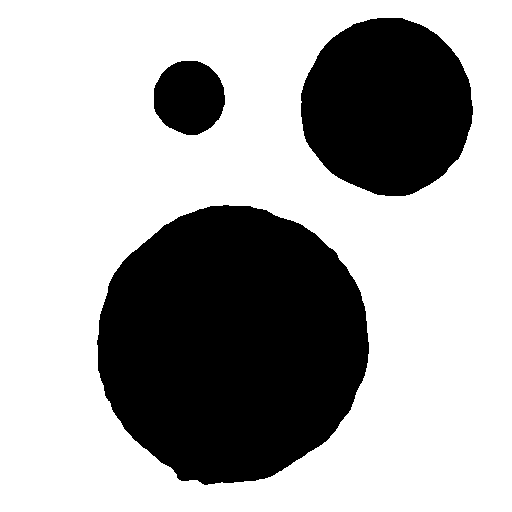

a highly detailed photorealistic image of a red tennis ball
(512, 512, 3) 255


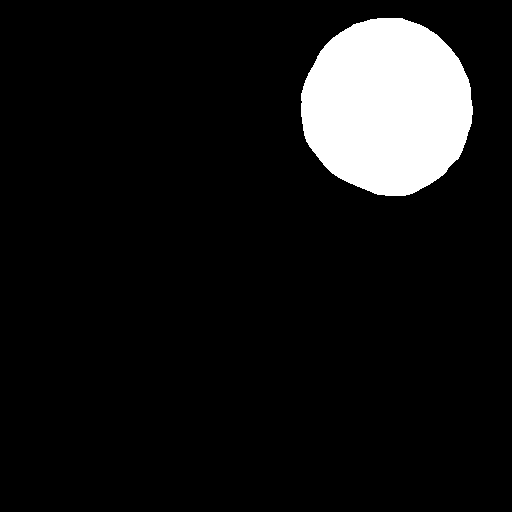

a highly detailed photorealistic image of a blue crystal ball
(512, 512, 3) 255


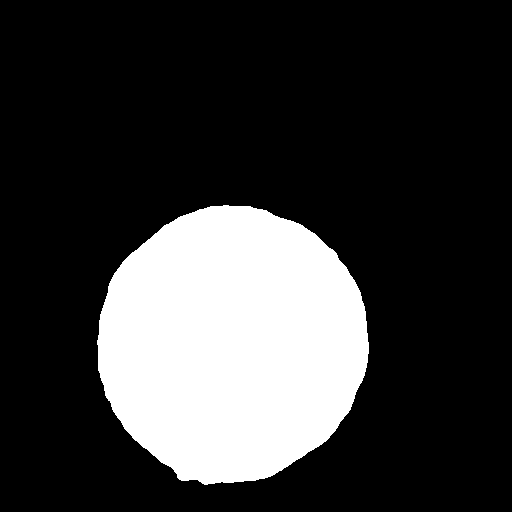

a highly detailed photorealistic image of a gold coin
(512, 512, 3) 255


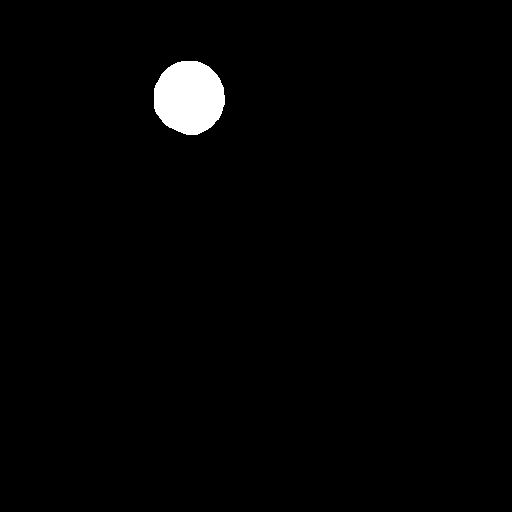

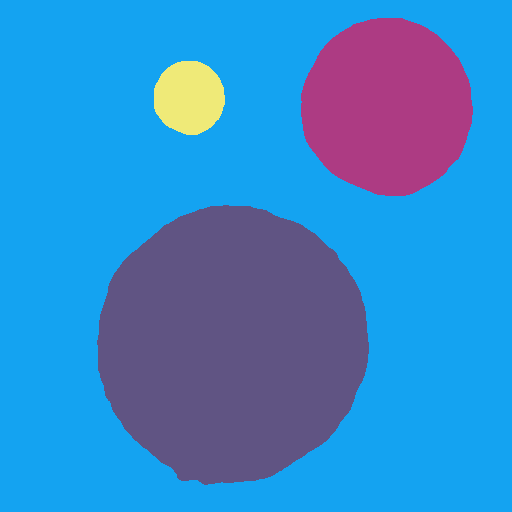

['a highly detailed photorealistic image of {a gold coin:7924463}, {a blue crystal ball:8606816} and {a red tennis ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red tennis ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a blue crystal ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a gold coin'}}


In [13]:
fp = 'evaldata/threeballs.psd'

example = psd_to_cocopanoptic(fp)
display_example(example)

In [14]:
# create prototype from example

def _replace_func(matchobj, key="", repl=""):
    # matchobj: "{<OBJA>:1234}", key="<OBJA>", repl="a sunny {day}", output: "a sunny {day:1234}"
    m = re.match("^[^\{]+\{([^\}]+)\}.*$", repl)
    src = matchobj.group(0)
    if m:
        corerepl = m.group(1)     # "day"
        src = src.replace(key, corerepl)    # "{day:1234}"
        ret = repl.replace("{" + corerepl + "}", src)
    else:
        ret = src.replace(key, repl)
    return ret
    

def replace_in_captions(x, repls):
    newcaptions = []
    for caption in x.captions:
        for k, v in repls.items():
            caption = re.sub(r"{{{k}:\d+}}".format(k=k), partial(_replace_func, key=k, repl=v), caption)
            caption = caption.replace(k, v)
        newcaptions.append(caption)

    new_seg_info = {}
    for regioncode, regioninfo in x.seg_info.items():
        caption = regioninfo["caption"]
        for k, v in repls.items():
            v = re.sub(r"\{([^\}]+)\}", r"\1", v)
            caption = caption.replace(k, v)
        new_seg_info[regioncode] = {"caption": caption}

    ret = deepcopy(x)
    ret.captions = newcaptions
    ret.seg_info = new_seg_info
    return ret

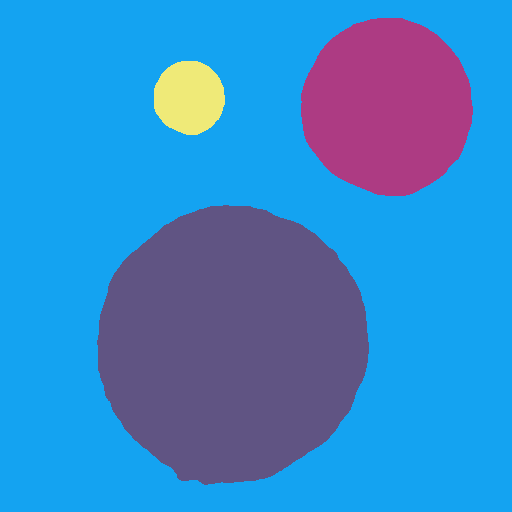

['a highly detailed photorealistic image of {<OBJ_A>:7924463}, {<OBJ_B>:8606816} and {<OBJ_C>:8600493} on {<OBJ_D>:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of <OBJ_D>'}, 8600493: {'caption': 'a highly detailed photorealistic image of <OBJ_C>'}, 8606816: {'caption': 'a highly detailed photorealistic image of <OBJ_B>'}, 7924463: {'caption': 'a highly detailed photorealistic image of <OBJ_A>'}}


In [16]:
repls = {
    "a gold coin": "<OBJ_A>",
    "a blue crystal ball": "<OBJ_B>",
    "a red tennis ball": "<OBJ_C>",
    "a wooden table": "<OBJ_D>"
}
prototype = replace_in_captions(example, repls)
display_example(prototype)

In [24]:
import random
import itertools

In [25]:
# setting one: balls
objects = ["a {color} crystal ball", "a {color} tennis ball", "a {color} ping pong ball"]
object_colors = ["red", "blue", "yellow"]
backgrounds = ["a wooden table", "grass"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        # print(objperm)
        for colorperm in itertools.permutations(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
    
    
# iterate through possible combinations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    specset = set()
    for objperm in itertools.combinations_with_replacement(objects, 3):
        # print(objperm)
        _spec = deepcopy(spec)
        for colorperm in itertools.combinations_with_replacement(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                _spec[posname] = obj.format(color=color)
            specset = set(_spec.values())
            if len(specset) < len(_spec):
                continue
            specs.append(deepcopy(_spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
            

72
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a red crystal ball', '<OBJ_B>': 'a blue ping pong ball', '<OBJ_C>': 'a yellow tennis ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a blue crystal ball', '<OBJ_B>': 'a yellow ping pong ball', '<OBJ_C>': 'a red tennis ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a blue ping pong ball', '<OBJ_B>': 'a yellow tennis ball', '<OBJ_C>': 'a red crystal ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow ping pong ball', '<OBJ_B>': 'a red crystal ball', '<OBJ_C>': 'a blue tennis ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a yellow tennis ball', '<OBJ_B>': 'a blue ping pong ball', '<OBJ_C>': 'a red crystal ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a blue ping pong ball', '<OBJ_B>': 'a red tennis ball', '<OBJ_C>': 'a yellow crystal ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow tennis ball', '<OBJ_B>': 'a red ping pong ball', '<OBJ_C>': 'a blue crystal ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a yellow tennis ball', '<OBJ_B>': 'a blue crystal ball', '<OBJ_C>': 'a 

In [27]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)
    
Path("evaldata/").mkdir(exist_ok=True)
with open("evaldata/threeballs3.pkl", "wb") as f:
    pkl.dump(examples, f)

with open("evaldata/threeballs3.spec.json", "w") as f:
    for i in range(len(retspecs)):
        retspecs[i]["i"] = i
    json.dump(retspecs, f, indent=4)
    


In [28]:
# setting one version two: colored balls
objects = ["a {color} ball", "a {color} ball", "a {color} ball"]
object_colors = ["red", "blue", "green", "pink", "white", "yellow"]
backgrounds = ["a wooden table", "grass"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        # print(objperm)
        for colorperm in itertools.permutations(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:20]
retspecs += specs

for spec in specs:
    print(spec)
    

1440
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pink ball', '<OBJ_B>': 'a yellow ball', '<OBJ_C>': 'a white ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a red ball', '<OBJ_B>': 'a white ball', '<OBJ_C>': 'a pink ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pink ball', '<OBJ_B>': 'a blue ball', '<OBJ_C>': 'a white ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a pink ball', '<OBJ_B>': 'a red ball', '<OBJ_C>': 'a white ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a yellow ball', '<OBJ_B>': 'a green ball', '<OBJ_C>': 'a pink ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pink ball', '<OBJ_B>': 'a blue ball', '<OBJ_C>': 'a white ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow ball', '<OBJ_B>': 'a white ball', '<OBJ_C>': 'a red ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a white ball', '<OBJ_B>': 'a red ball', '<OBJ_C>': 'a yellow ball'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pink ball', '<OBJ_B>': 'a red ball', '<OBJ_C>': 'a blue ball'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a red 

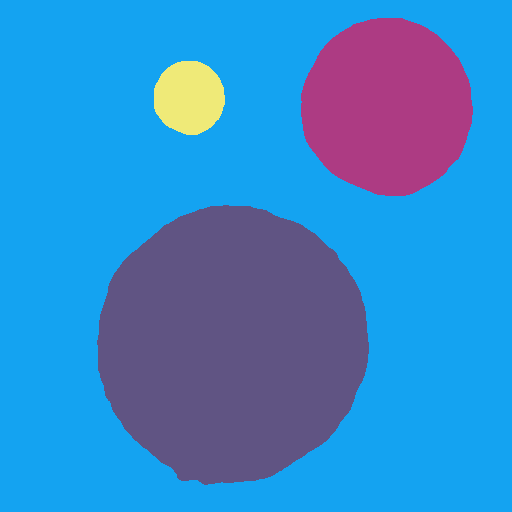

['a highly detailed photorealistic image of {a pink ball:7924463}, {a yellow ball:8606816} and {a white ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


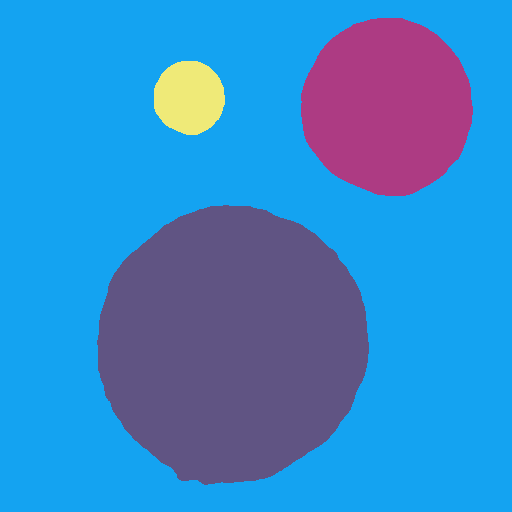

['a highly detailed photorealistic image of {a red ball:7924463}, {a white ball:8606816} and {a pink ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pink ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a white ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red ball'}}


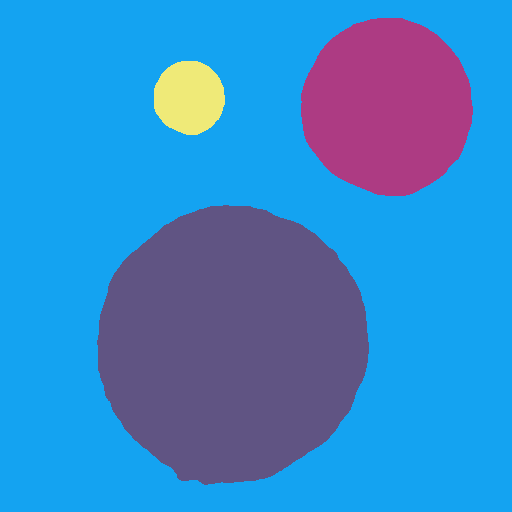

['a highly detailed photorealistic image of {a pink ball:7924463}, {a blue ball:8606816} and {a white ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


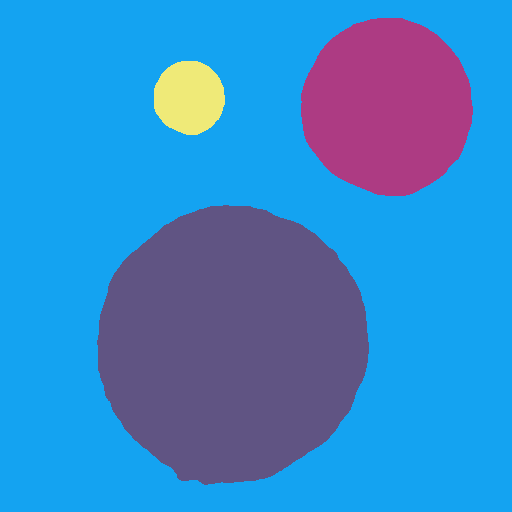

['a highly detailed photorealistic image of {a pink ball:7924463}, {a red ball:8606816} and {a white ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


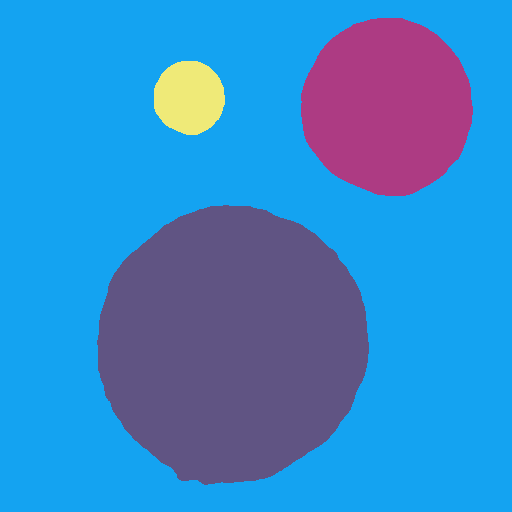

['a highly detailed photorealistic image of {a yellow ball:7924463}, {a green ball:8606816} and {a pink ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pink ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow ball'}}


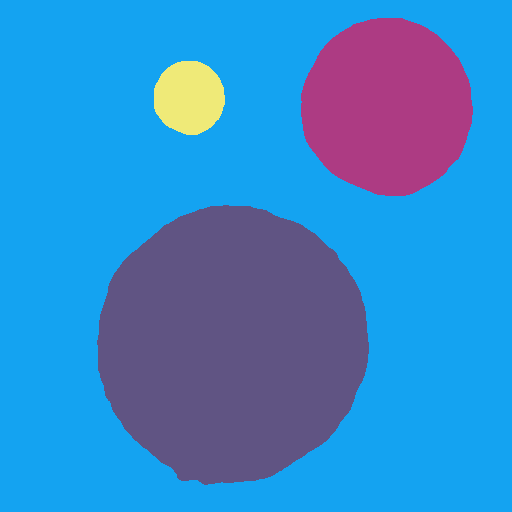

['a highly detailed photorealistic image of {a pink ball:7924463}, {a blue ball:8606816} and {a white ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


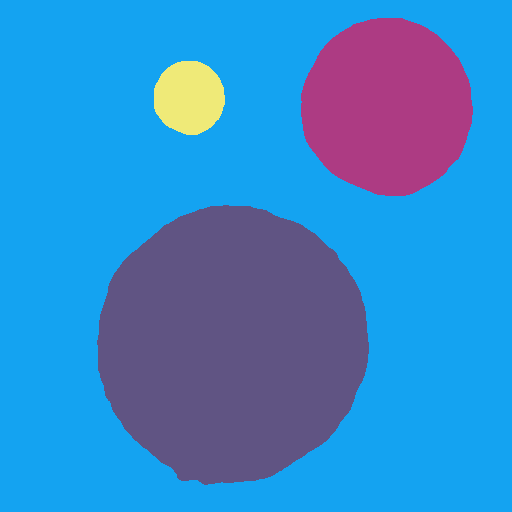

['a highly detailed photorealistic image of {a yellow ball:7924463}, {a white ball:8606816} and {a red ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a white ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow ball'}}


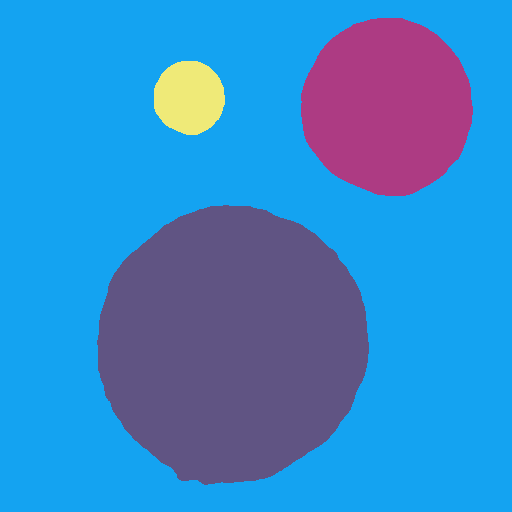

['a highly detailed photorealistic image of {a white ball:7924463}, {a red ball:8606816} and {a yellow ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a white ball'}}


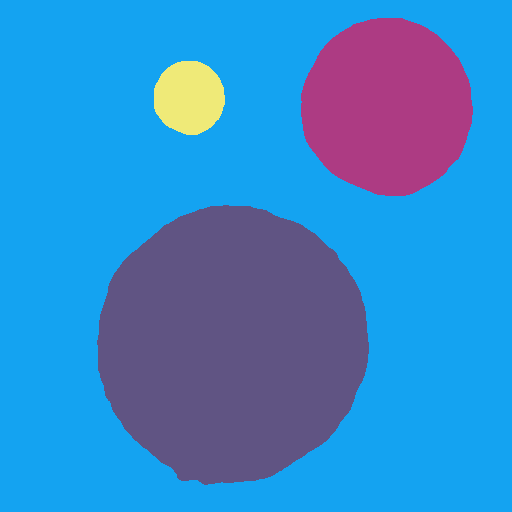

['a highly detailed photorealistic image of {a pink ball:7924463}, {a red ball:8606816} and {a blue ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


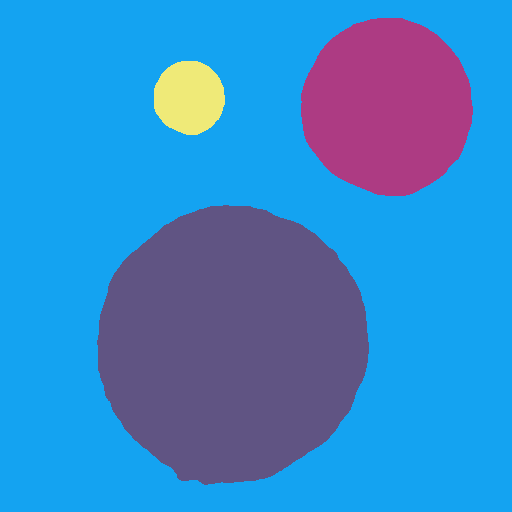

['a highly detailed photorealistic image of {a red ball:7924463}, {a blue ball:8606816} and {a pink ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pink ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red ball'}}


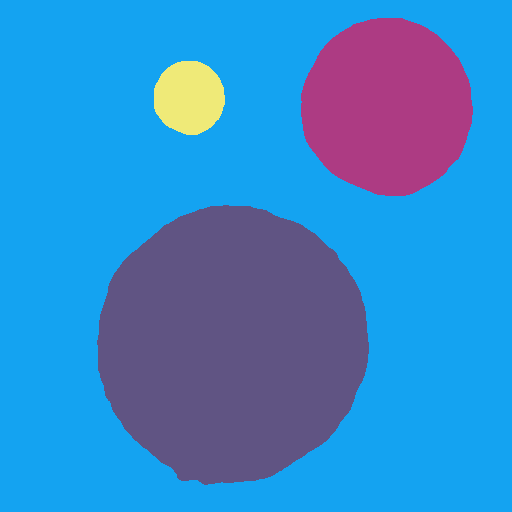

['a highly detailed photorealistic image of {a red ball:7924463}, {a white ball:8606816} and {a blue ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a white ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red ball'}}


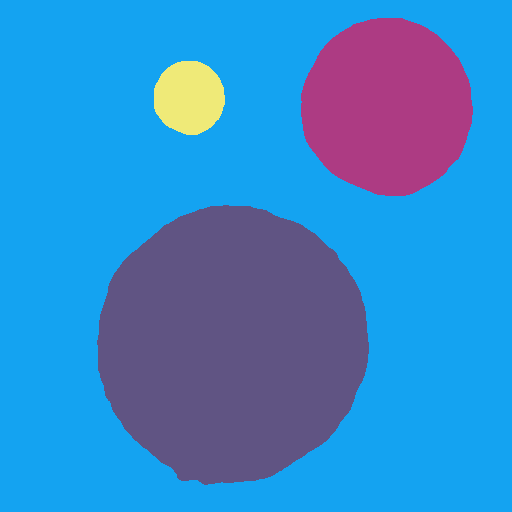

['a highly detailed photorealistic image of {a yellow ball:7924463}, {a white ball:8606816} and {a pink ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a pink ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a white ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow ball'}}


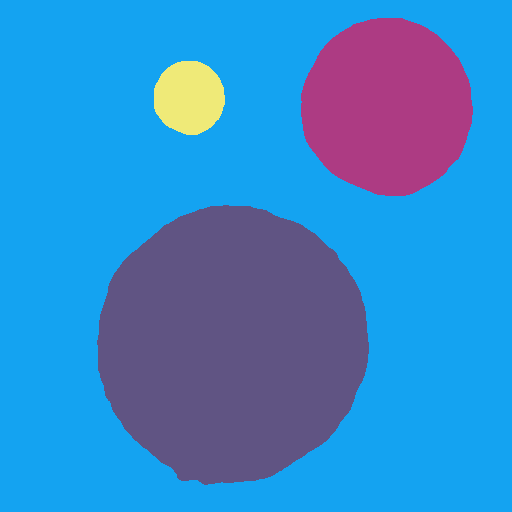

['a highly detailed photorealistic image of {a red ball:7924463}, {a green ball:8606816} and {a yellow ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red ball'}}


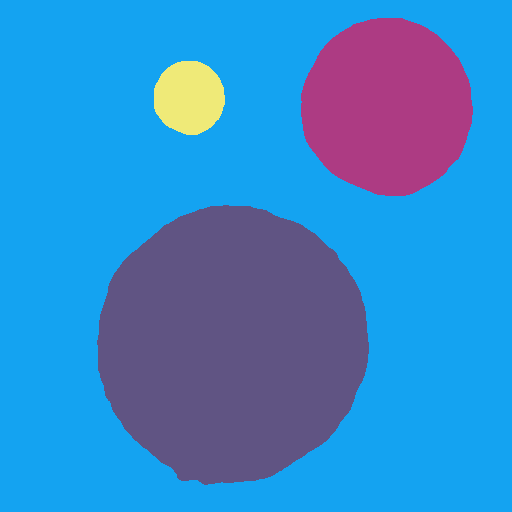

['a highly detailed photorealistic image of {a pink ball:7924463}, {a white ball:8606816} and {a green ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a white ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


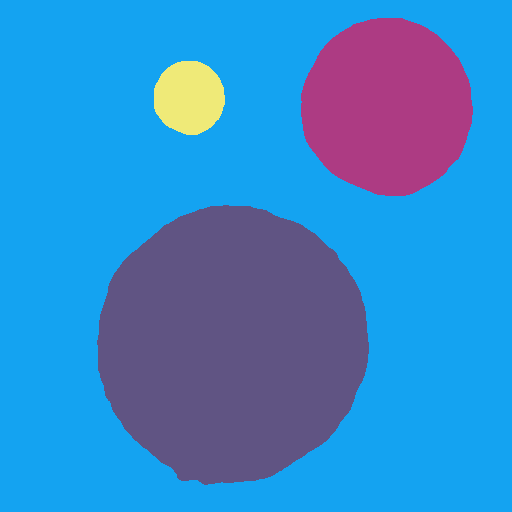

['a highly detailed photorealistic image of {a yellow ball:7924463}, {a green ball:8606816} and {a blue ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow ball'}}


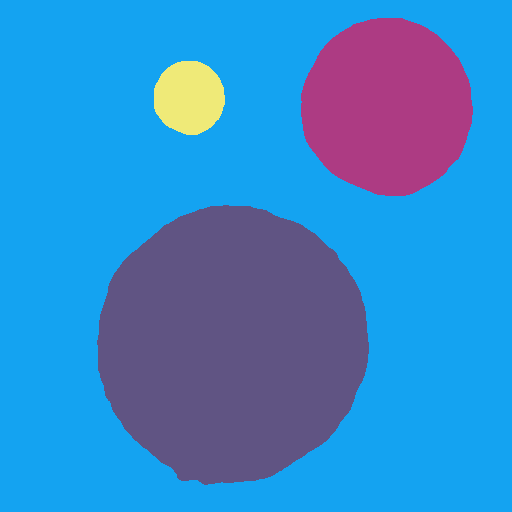

['a highly detailed photorealistic image of {a green ball:7924463}, {a red ball:8606816} and {a white ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green ball'}}


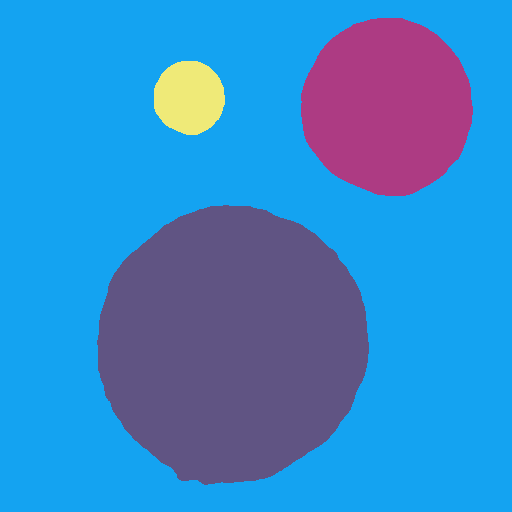

['a highly detailed photorealistic image of {a yellow ball:7924463}, {a green ball:8606816} and {a red ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow ball'}}


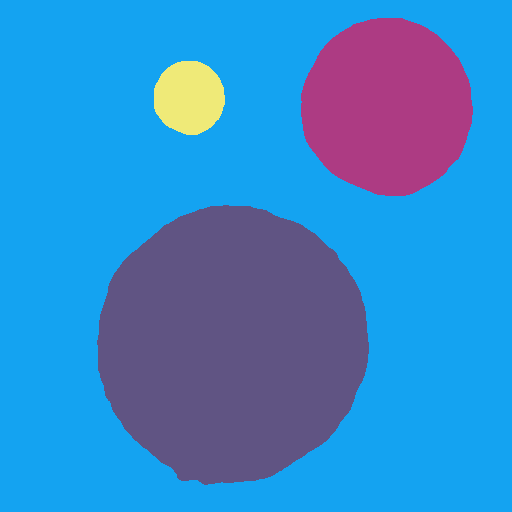

['a highly detailed photorealistic image of {a green ball:7924463}, {a red ball:8606816} and {a blue ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a blue ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green ball'}}


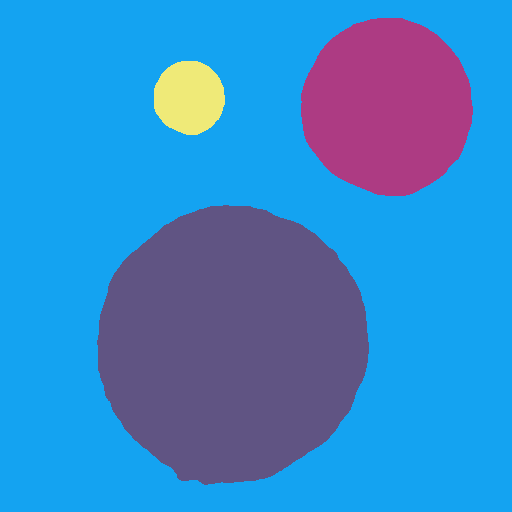

['a highly detailed photorealistic image of {a pink ball:7924463}, {a yellow ball:8606816} and {a white ball:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a white ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


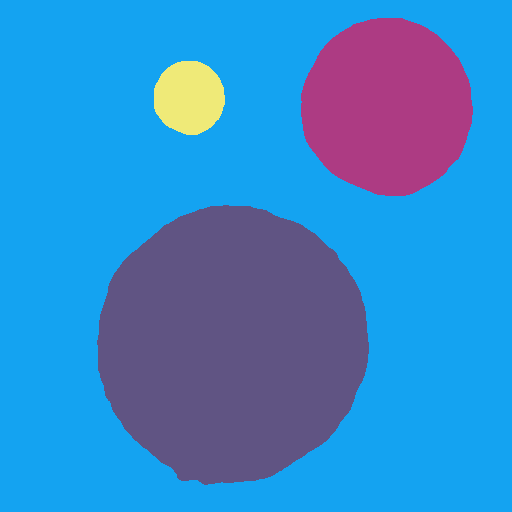

['a highly detailed photorealistic image of {a pink ball:7924463}, {a white ball:8606816} and {a green ball:8600493} on {a wooden table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a wooden table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green ball'}, 8606816: {'caption': 'a highly detailed photorealistic image of a white ball'}, 7924463: {'caption': 'a highly detailed photorealistic image of a pink ball'}}


In [30]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)

outname = "threecoloredballs3"
    
Path("evaldata/").mkdir(exist_ok=True)
with open(f"evaldata/{outname}.pkl", "wb") as f:
    pkl.dump(examples, f)

with open(f"evaldata/{outname}.spec.json", "w") as f:
    for i in range(len(retspecs)):
        retspecs[i]["i"] = i
    json.dump(retspecs, f, indent=4)
    
    


In [31]:
# setting two: fruits
objects = ["a {color} orange", "a {color} apple", "a {color} watermelon"]
object_colors = ["red", "green", "yellow"]
backgrounds = ["a kitchen table", "grass", "a fruit basket"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        # print(objperm)
        for colorperm in itertools.permutations(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                spec[posname] = obj.format(color=color)
            specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
    
    
# iterate through possible combinations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    specset = set()
    for objperm in itertools.combinations_with_replacement(objects, 3):
        # print(objperm)
        _spec = deepcopy(spec)
        for colorperm in itertools.combinations_with_replacement(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                _spec[posname] = obj.format(color=color)
            specset = set(_spec.values())
            if len(specset) < len(_spec):
                continue
            specs.append(deepcopy(_spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)
            

108
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a green apple', '<OBJ_B>': 'a yellow orange', '<OBJ_C>': 'a red watermelon'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a yellow apple', '<OBJ_B>': 'a red orange', '<OBJ_C>': 'a green watermelon'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a red watermelon', '<OBJ_B>': 'a green orange', '<OBJ_C>': 'a yellow apple'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a yellow watermelon', '<OBJ_B>': 'a red orange', '<OBJ_C>': 'a green apple'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a green orange', '<OBJ_B>': 'a yellow apple', '<OBJ_C>': 'a red watermelon'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a red apple', '<OBJ_B>': 'a yellow orange', '<OBJ_C>': 'a green watermelon'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a yellow apple', '<OBJ_B>': 'a red watermelon', '<OBJ_C>': 'a green orange'}
{'<OBJ_D>': 'a fruit basket', '<OBJ_A>': 'a red watermelon', '<OBJ_B>': 'a green apple', '<OBJ_C>': 'a yellow orange'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a red o

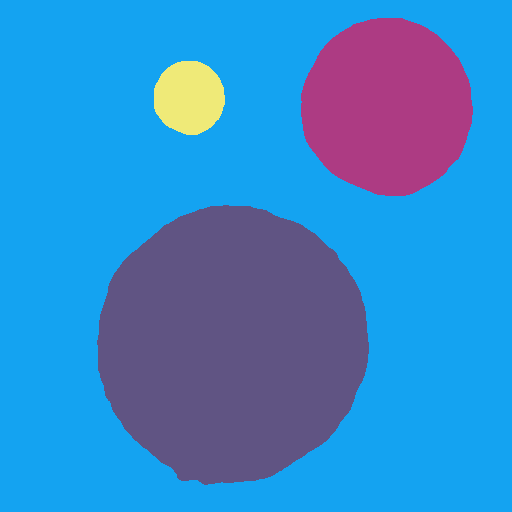

['a highly detailed photorealistic image of {a green apple:7924463}, {a yellow orange:8606816} and {a red watermelon:8600493} on {a fruit basket:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a fruit basket'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green apple'}}


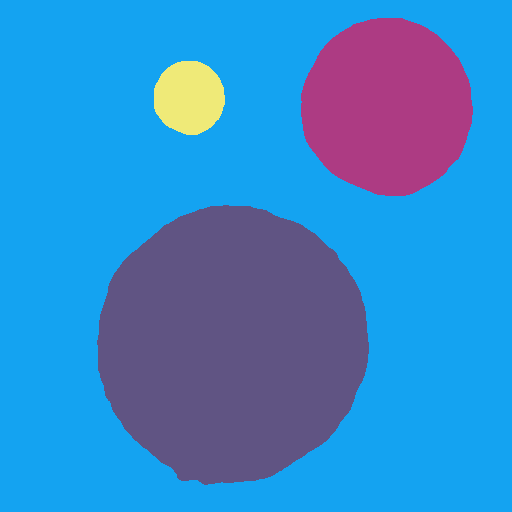

['a highly detailed photorealistic image of {a yellow apple:7924463}, {a red orange:8606816} and {a green watermelon:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow apple'}}


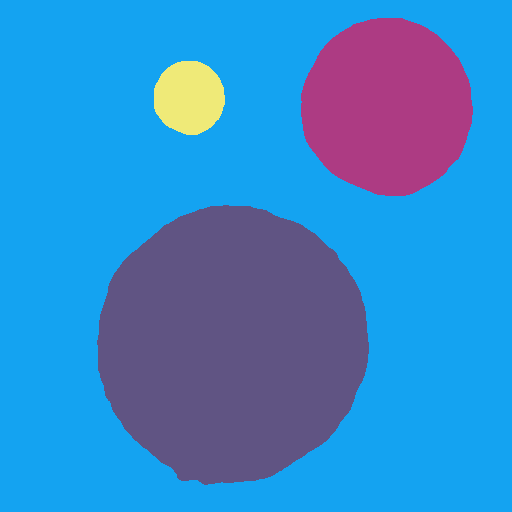

['a highly detailed photorealistic image of {a red watermelon:7924463}, {a green orange:8606816} and {a yellow apple:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow apple'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red watermelon'}}


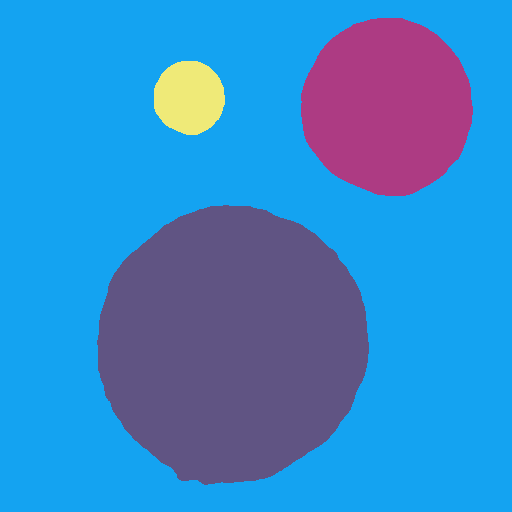

['a highly detailed photorealistic image of {a yellow watermelon:7924463}, {a red orange:8606816} and {a green apple:8600493} on {a fruit basket:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a fruit basket'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green apple'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow watermelon'}}


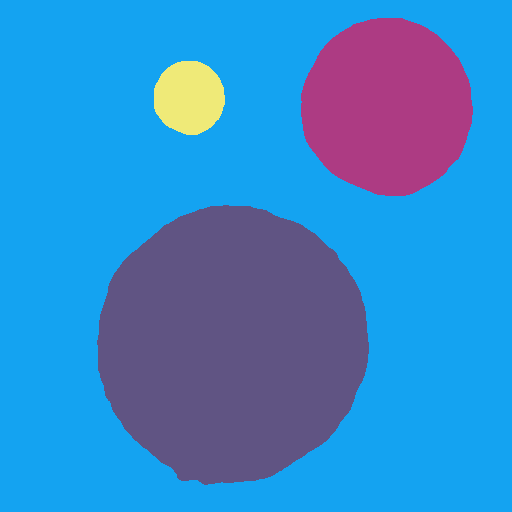

['a highly detailed photorealistic image of {a green orange:7924463}, {a yellow apple:8606816} and {a red watermelon:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green orange'}}


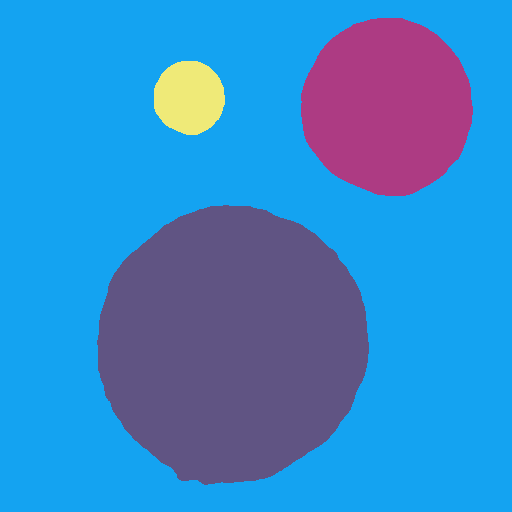

['a highly detailed photorealistic image of {a red apple:7924463}, {a yellow orange:8606816} and {a green watermelon:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red apple'}}


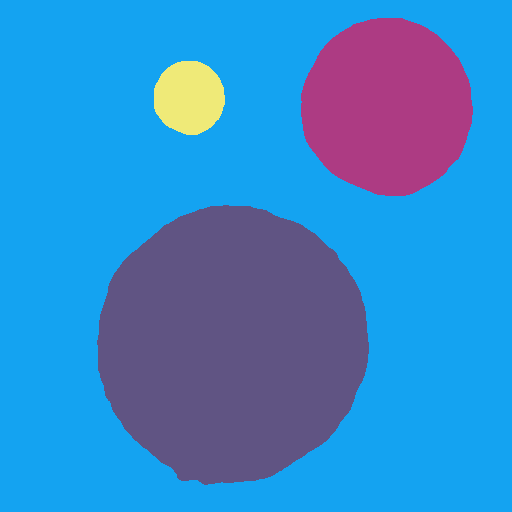

['a highly detailed photorealistic image of {a yellow apple:7924463}, {a red watermelon:8606816} and {a green orange:8600493} on {a fruit basket:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a fruit basket'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red watermelon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a yellow apple'}}


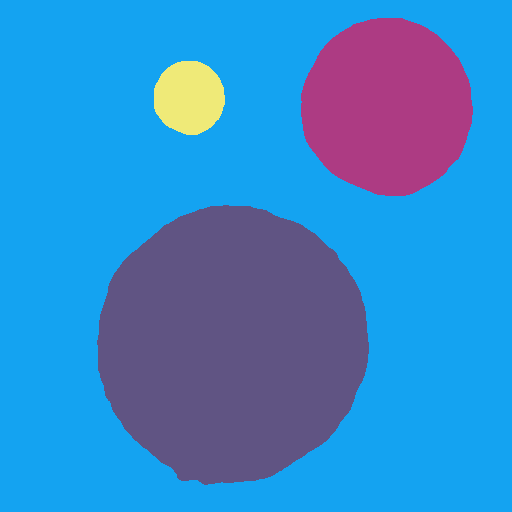

['a highly detailed photorealistic image of {a red watermelon:7924463}, {a green apple:8606816} and {a yellow orange:8600493} on {a fruit basket:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a fruit basket'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red watermelon'}}


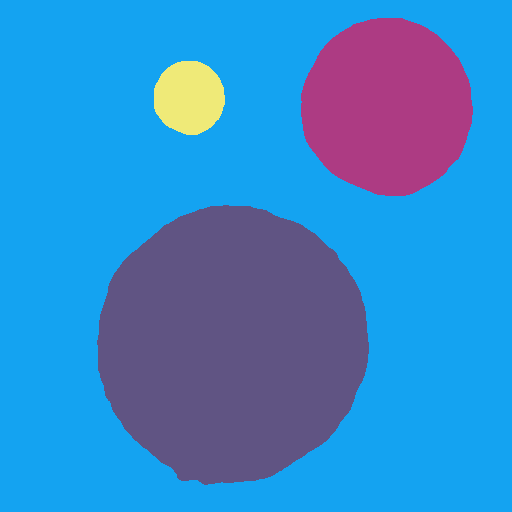

['a highly detailed photorealistic image of {a red orange:7924463}, {a yellow watermelon:8606816} and {a green apple:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green apple'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow watermelon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red orange'}}


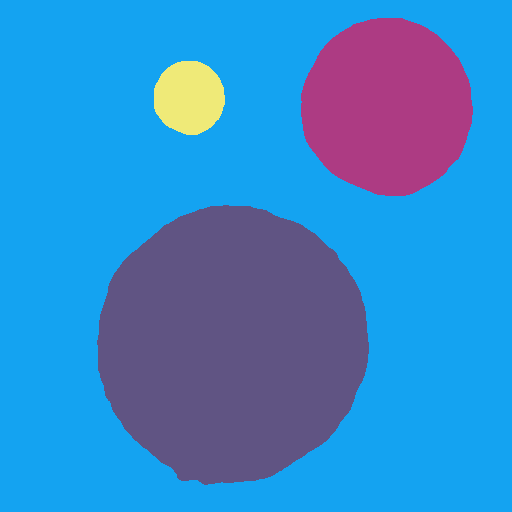

['a highly detailed photorealistic image of {a green watermelon:7924463}, {a yellow apple:8606816} and {a red orange:8600493} on {a fruit basket:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a fruit basket'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green watermelon'}}


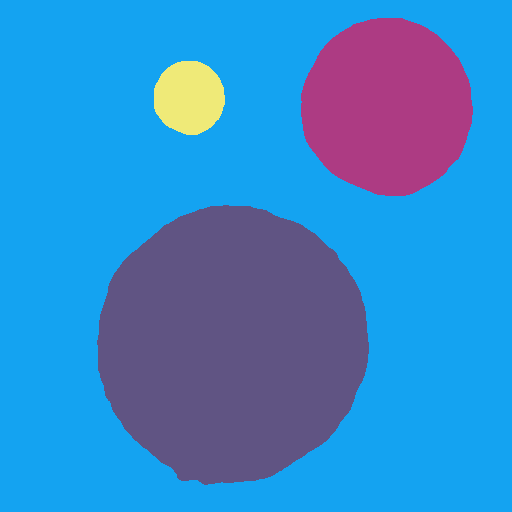

['a highly detailed photorealistic image of {a red orange:7924463}, {a red apple:8606816} and {a green apple:8600493} on {a fruit basket:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a fruit basket'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green apple'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red orange'}}


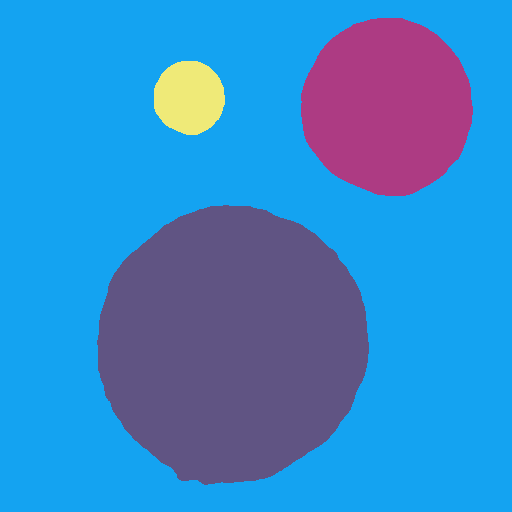

['a highly detailed photorealistic image of {a red apple:7924463}, {a yellow apple:8606816} and {a yellow watermelon:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red apple'}}


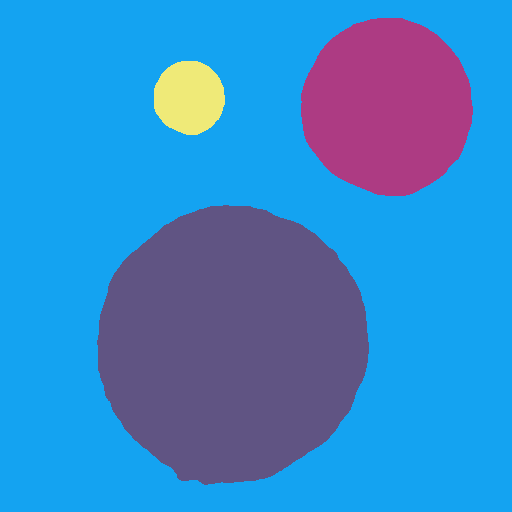

['a highly detailed photorealistic image of {a green orange:7924463}, {a yellow apple:8606816} and {a yellow watermelon:8600493} on {a fruit basket:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a fruit basket'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a yellow apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green orange'}}


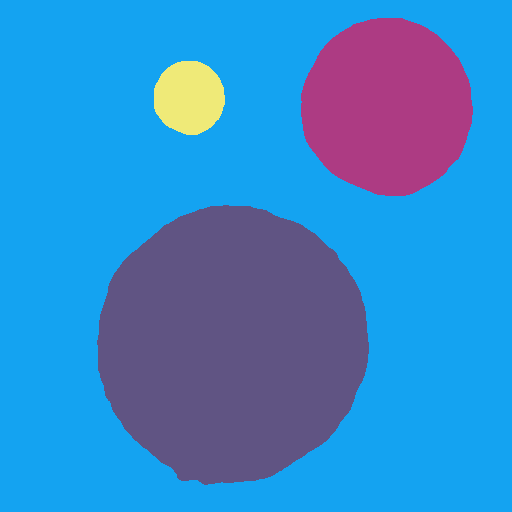

['a highly detailed photorealistic image of {a red apple:7924463}, {a green watermelon:8606816} and {a yellow watermelon:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green watermelon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red apple'}}


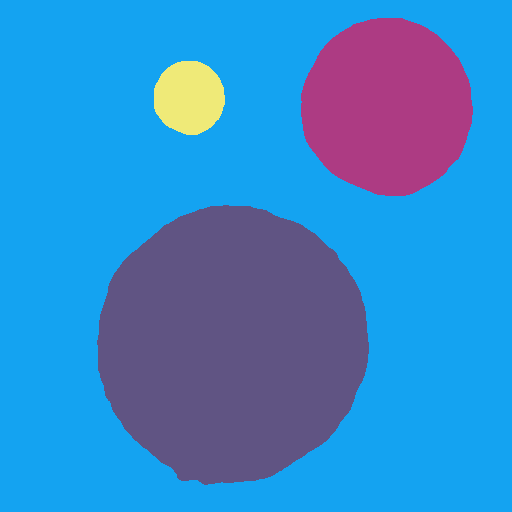

['a highly detailed photorealistic image of {a red orange:7924463}, {a red apple:8606816} and {a yellow watermelon:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red orange'}}


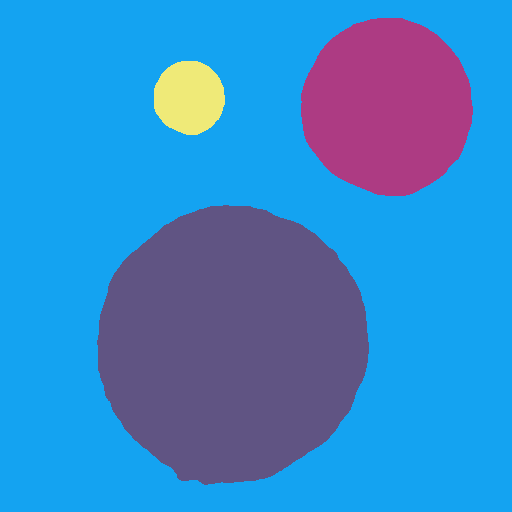

['a highly detailed photorealistic image of {a red orange:7924463}, {a red watermelon:8606816} and {a green watermelon:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a green watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red watermelon'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red orange'}}


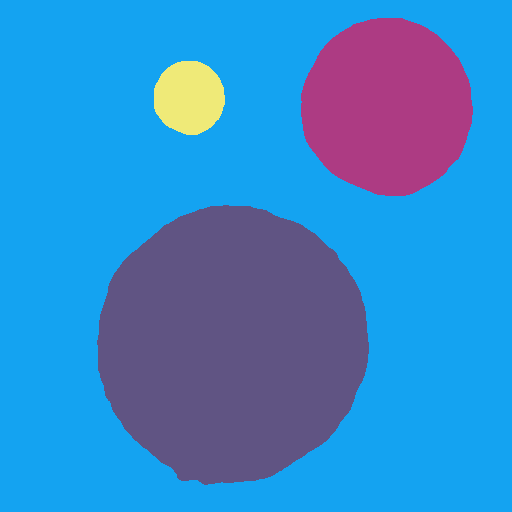

['a highly detailed photorealistic image of {a red orange:7924463}, {a green orange:8606816} and {a yellow orange:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow orange'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green orange'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red orange'}}


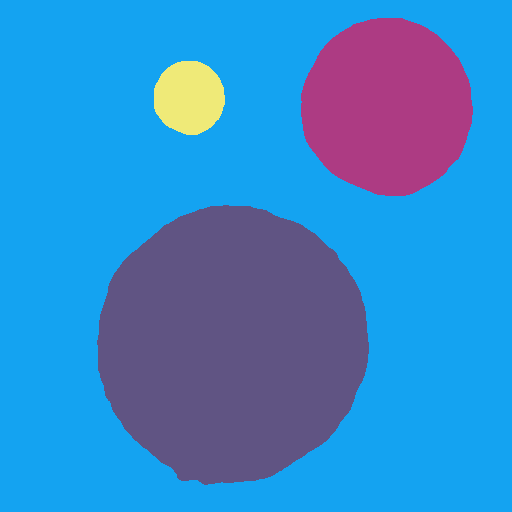

['a highly detailed photorealistic image of {a red apple:7924463}, {a green apple:8606816} and {a yellow watermelon:8600493} on {a kitchen table:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a kitchen table'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red apple'}}


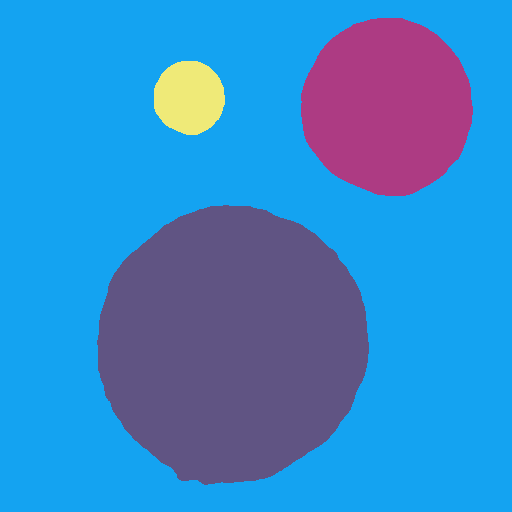

['a highly detailed photorealistic image of {a green orange:7924463}, {a green apple:8606816} and {a yellow watermelon:8600493} on {a fruit basket:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of a fruit basket'}, 8600493: {'caption': 'a highly detailed photorealistic image of a yellow watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a green apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a green orange'}}


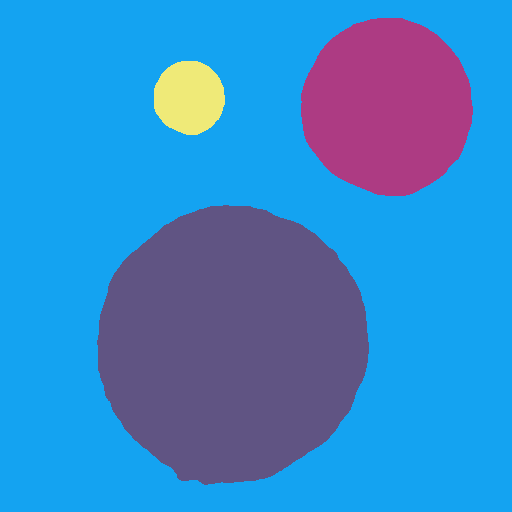

['a highly detailed photorealistic image of {a red orange:7924463}, {a red apple:8606816} and {a red watermelon:8600493} on {grass:15835924}.']
{15835924: {'caption': 'a highly detailed photorealistic image of grass'}, 8600493: {'caption': 'a highly detailed photorealistic image of a red watermelon'}, 8606816: {'caption': 'a highly detailed photorealistic image of a red apple'}, 7924463: {'caption': 'a highly detailed photorealistic image of a red orange'}}


In [32]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)

outname = "threefruits3"
    
Path("evaldata/").mkdir(exist_ok=True)
with open(f"evaldata/{outname}.pkl", "wb") as f:
    pkl.dump(examples, f)

with open(f"evaldata/{outname}.spec.json", "w") as f:
    for i in range(len(retspecs)):
        retspecs[i]["i"] = i
    json.dump(retspecs, f, indent=4)
    
    


In [33]:
# setting two, version 2: simple fruits
objects = ["an orange", "a red apple", "a green apple", "a watermelon", "a kiwi", "a chestnut", "a walnut", "a peach", "a grape"]
backgrounds = ["a kitchen table", "grass"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        for posname, obj in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm):
            spec[posname] = obj.format(color=color)
        specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:20]
retspecs += specs

for spec in specs:
    print(spec)
    

1008
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a peach', '<OBJ_B>': 'a watermelon', '<OBJ_C>': 'a grape'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a green apple', '<OBJ_B>': 'a chestnut', '<OBJ_C>': 'a watermelon'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'an orange', '<OBJ_B>': 'a kiwi', '<OBJ_C>': 'a walnut'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a green apple', '<OBJ_B>': 'an orange', '<OBJ_C>': 'a grape'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a watermelon', '<OBJ_B>': 'a grape', '<OBJ_C>': 'a kiwi'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a red apple', '<OBJ_B>': 'a green apple', '<OBJ_C>': 'a chestnut'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a kiwi', '<OBJ_B>': 'a peach', '<OBJ_C>': 'a walnut'}
{'<OBJ_D>': 'grass', '<OBJ_A>': 'a peach', '<OBJ_B>': 'a kiwi', '<OBJ_C>': 'a chestnut'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a grape', '<OBJ_B>': 'a walnut', '<OBJ_C>': 'a peach'}
{'<OBJ_D>': 'a kitchen table', '<OBJ_A>': 'a red apple', '<OBJ_B>': 'a chestnut', '<OBJ_C>': 'a green apple'}
{'<

In [34]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)

outname = "threesimplefruits3"
    
Path("evaldata/").mkdir(exist_ok=True)
with open(f"evaldata/{outname}.pkl", "wb") as f:
    pkl.dump(examples, f)

with open(f"evaldata/{outname}.spec.json", "w") as f:
    for i in range(len(retspecs)):
        retspecs[i]["i"] = i
    json.dump(retspecs, f, indent=4)
    
    


In [39]:
# setting two, version 2: all yellow
objects = ["a lemon", "a gold coin", "cheese wheel", "a yellow smiley face pin", "a yellow pancake", "a dandelion", "a slice of banana"]
backgrounds = ["a wooden table"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        for posname, obj in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm):
            spec[posname] = obj.format(color=color)
        specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:20]
retspecs += specs

for spec in specs:
    print(spec)
    

210
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow smiley face pin', '<OBJ_B>': 'a dandelion', '<OBJ_C>': 'a lemon'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow pancake', '<OBJ_B>': 'a gold coin', '<OBJ_C>': 'a yellow smiley face pin'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a gold coin', '<OBJ_B>': 'a yellow pancake', '<OBJ_C>': 'cheese wheel'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a yellow pancake', '<OBJ_B>': 'a slice of banana', '<OBJ_C>': 'a yellow smiley face pin'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a dandelion', '<OBJ_B>': 'cheese wheel', '<OBJ_C>': 'a gold coin'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'cheese wheel', '<OBJ_B>': 'a lemon', '<OBJ_C>': 'a slice of banana'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a dandelion', '<OBJ_B>': 'a yellow smiley face pin', '<OBJ_C>': 'a gold coin'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'cheese wheel', '<OBJ_B>': 'a yellow pancake', '<OBJ_C>': 'a lemon'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a dandelion', 

In [40]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)

outname = "threeyellow3"
    
Path("evaldata/").mkdir(exist_ok=True)
with open(f"evaldata/{outname}.pkl", "wb") as f:
    pkl.dump(examples, f)

with open(f"evaldata/{outname}.spec.json", "w") as f:
    for i in range(len(retspecs)):
        retspecs[i]["i"] = i
    json.dump(retspecs, f, indent=4)
    
    


In [45]:
# setting two, version 2: all oranges
objects = ["an orange", "a pumpkin", "an apricot", "a persimmon", "donald trump's face"]
backgrounds = ["a wooden table"]

retspecs = []
retspecs.append({
    "<OBJ_A>": "an apricot",
    "<OBJ_B>": "a pumpkin",
    "<OBJ_C>": "an orange",
    "<OBJ_D>": "a wooden table"
})

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    for objperm in itertools.permutations(objects, 3):
        for posname, obj in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm):
            spec[posname] = obj.format(color=color)
        if objects[-1] in spec.values():
            if random.random() < 1.1: #0.9:
                continue
        if objects[-1] == spec["<OBJ_A>"] or objects[-1] == spec["<OBJ_C>"]:
            continue
        specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:19]
retspecs += specs

for spec in retspecs:
    print(spec)
    

24
{'<OBJ_A>': 'an apricot', '<OBJ_B>': 'a pumpkin', '<OBJ_C>': 'an orange', '<OBJ_D>': 'a wooden table'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pumpkin', '<OBJ_B>': 'an apricot', '<OBJ_C>': 'an orange'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a persimmon', '<OBJ_B>': 'an orange', '<OBJ_C>': 'an apricot'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'an apricot', '<OBJ_B>': 'a persimmon', '<OBJ_C>': 'an orange'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pumpkin', '<OBJ_B>': 'an orange', '<OBJ_C>': 'an apricot'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'an orange', '<OBJ_B>': 'a pumpkin', '<OBJ_C>': 'a persimmon'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a persimmon', '<OBJ_B>': 'a pumpkin', '<OBJ_C>': 'an orange'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'an apricot', '<OBJ_B>': 'a pumpkin', '<OBJ_C>': 'a persimmon'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'an orange', '<OBJ_B>': 'a persimmon', '<OBJ_C>': 'an apricot'}
{'<OBJ_D>': 'a wooden table', '<OBJ_A>': 'a pumpkin', '<OBJ_

In [46]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)

outname = "threeorange3"
    
Path("evaldata/").mkdir(exist_ok=True)
with open(f"evaldata/{outname}.pkl", "wb") as f:
    pkl.dump(examples, f)

with open(f"evaldata/{outname}.spec.json", "w") as f:
    for i in range(len(retspecs)):
        retspecs[i]["i"] = i
    json.dump(retspecs, f, indent=4)
    
    


Unknown image resource 1092


a photo of <OBJ_E>
(512, 512, 3) 255


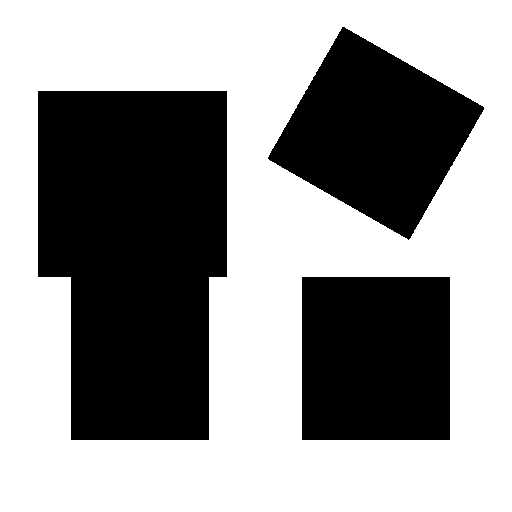

a photo of <OBJ_A>
(512, 512, 3) 255


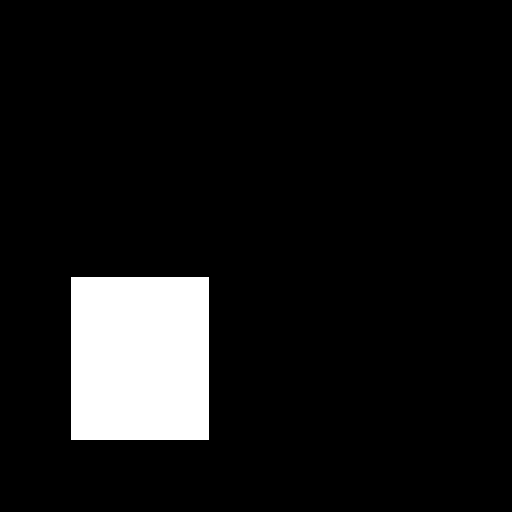

a photo of <OBJ_B>
(512, 512, 3) 255


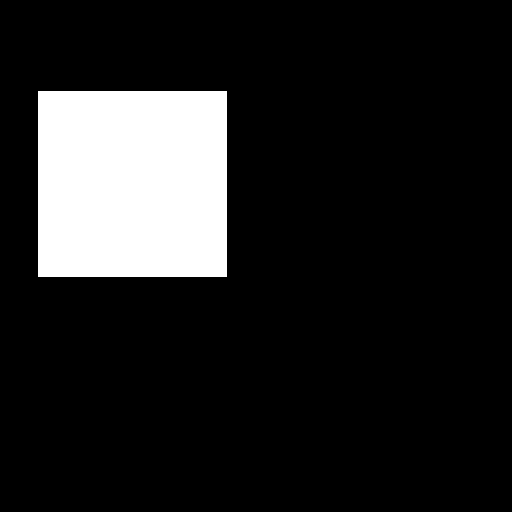

a photo of <OBJ_C>
(512, 512, 3) 255


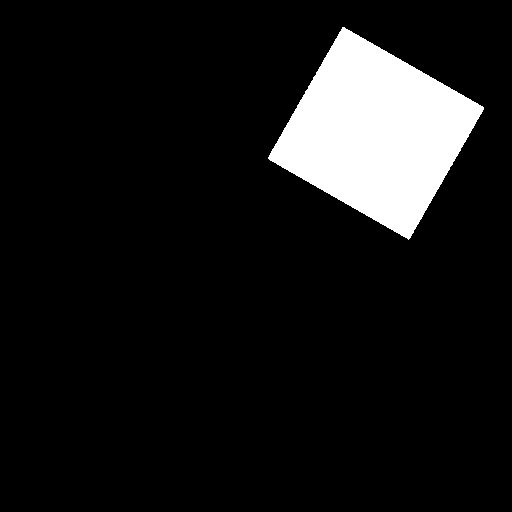

a photo of <OBJ_D>
(512, 512, 3) 255


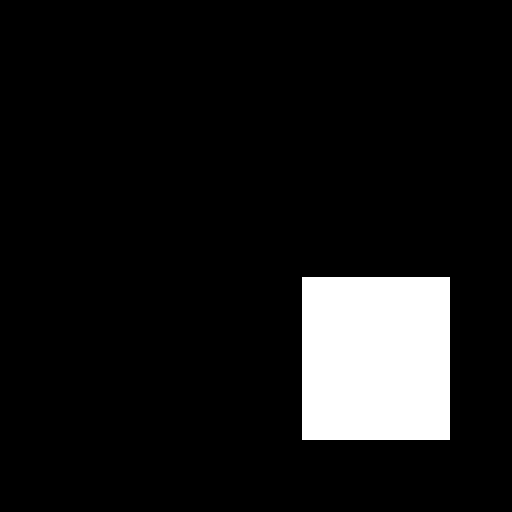

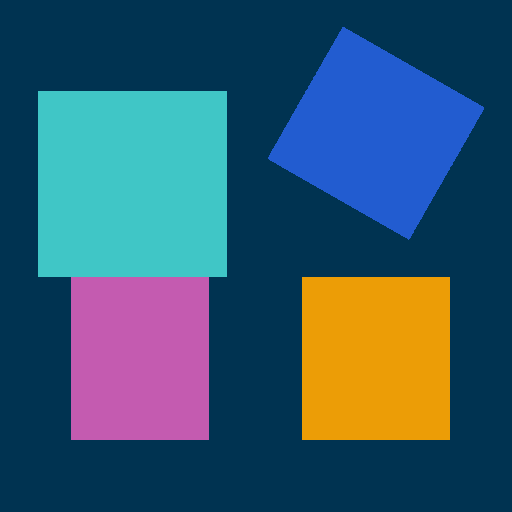

['a photo of {<OBJ_B>:11557828} on top of {<OBJ_A>:13026880}, and to the right {<OBJ_C>:13655074} falling on {<OBJ_D>:433644}. Background is {<OBJ_E>:5321472}.']
{5321472: {'caption': 'a photo of <OBJ_E>'}, 11557828: {'caption': 'a photo of <OBJ_A>'}, 13026880: {'caption': 'a photo of <OBJ_B>'}, 13655074: {'caption': 'a photo of <OBJ_C>'}, 433644: {'caption': 'a photo of <OBJ_D>'}}


In [52]:
fp = 'evaldata/foursquares.psd'

torch.manual_seed(48)
prototype = psd_to_cocopanoptic(fp)
display_example(prototype)

In [53]:
# setting three: four squares
objects = ["an old-school tv", "a cardboard box", "a square watermelon", "a concrete block", "spongebob", 
           "a yellow book", "a washing machine", "a gopro camera"]
backgrounds = ["a lush forest", "a brick wall", "a living room"]

retspecs = []

# iterate through possible permutations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_E>": bgr}
    for objperm in itertools.permutations(objects, 4):
        for posname, obj in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>", "<OBJ_D>"], objperm):
            spec[posname] = obj
        specs.append(deepcopy(spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:20]
retspecs += specs

for spec in specs:
    print(spec)
    
"""
# iterate through possible combinations
specs = []
for bgr in backgrounds:
    spec = {"<OBJ_D>": bgr}
    specset = set()
    for objperm in itertools.combinations_with_replacement(objects, 3):
        # print(objperm)
        _spec = deepcopy(spec)
        for colorperm in itertools.combinations_with_replacement(object_colors, 3):
            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):
                _spec[posname] = obj.format(color=color)
            specset = set(_spec.values())
            if len(specset) < len(_spec):
                continue
            specs.append(deepcopy(_spec))
            
print(len(specs))
random.shuffle(specs)
specs = specs[:10]
retspecs += specs

for spec in specs:
    print(spec)

#"""

5040
{'<OBJ_E>': 'a living room', '<OBJ_A>': 'a concrete block', '<OBJ_B>': 'a yellow book', '<OBJ_C>': 'a gopro camera', '<OBJ_D>': 'spongebob'}
{'<OBJ_E>': 'a lush forest', '<OBJ_A>': 'spongebob', '<OBJ_B>': 'a gopro camera', '<OBJ_C>': 'a cardboard box', '<OBJ_D>': 'an old-school tv'}
{'<OBJ_E>': 'a brick wall', '<OBJ_A>': 'a square watermelon', '<OBJ_B>': 'a gopro camera', '<OBJ_C>': 'a concrete block', '<OBJ_D>': 'spongebob'}
{'<OBJ_E>': 'a lush forest', '<OBJ_A>': 'a washing machine', '<OBJ_B>': 'spongebob', '<OBJ_C>': 'a cardboard box', '<OBJ_D>': 'an old-school tv'}
{'<OBJ_E>': 'a brick wall', '<OBJ_A>': 'a washing machine', '<OBJ_B>': 'spongebob', '<OBJ_C>': 'a cardboard box', '<OBJ_D>': 'a square watermelon'}
{'<OBJ_E>': 'a brick wall', '<OBJ_A>': 'a concrete block', '<OBJ_B>': 'a square watermelon', '<OBJ_C>': 'a yellow book', '<OBJ_D>': 'a washing machine'}
{'<OBJ_E>': 'a lush forest', '<OBJ_A>': 'a gopro camera', '<OBJ_B>': 'a washing machine', '<OBJ_C>': 'a square waterme

'\n# iterate through possible combinations\nspecs = []\nfor bgr in backgrounds:\n    spec = {"<OBJ_D>": bgr}\n    specset = set()\n    for objperm in itertools.combinations_with_replacement(objects, 3):\n        # print(objperm)\n        _spec = deepcopy(spec)\n        for colorperm in itertools.combinations_with_replacement(object_colors, 3):\n            for posname, obj, color in zip(["<OBJ_A>", "<OBJ_B>", "<OBJ_C>"], objperm, colorperm):\n                _spec[posname] = obj.format(color=color)\n            specset = set(_spec.values())\n            if len(specset) < len(_spec):\n                continue\n            specs.append(deepcopy(_spec))\n            \nprint(len(specs))\nrandom.shuffle(specs)\nspecs = specs[:10]\nretspecs += specs\n\nfor spec in specs:\n    print(spec)\n\n#'

In [54]:
examples = []
for spec in retspecs:
    x = replace_in_captions(prototype, spec)
    display_example(x)
    examples.append(x)

outname = "foursquares3"
    
Path("evaldata/").mkdir(exist_ok=True)
with open(f"evaldata/{outname}.pkl", "wb") as f:
    pkl.dump(examples, f)

with open(f"evaldata/{outname}.spec.json", "w") as f:
    for i in range(len(retspecs)):
        retspecs[i]["i"] = i
    json.dump(retspecs, f, indent=4)
    
    


a photo of <OBJ_D>
(512, 512, 3) 255


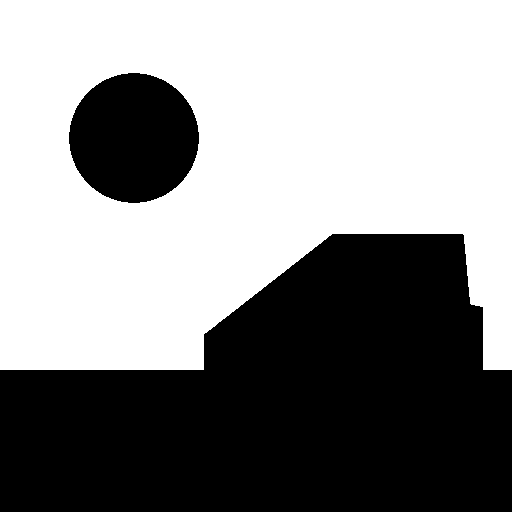

a photo of <OBJ_A>
(512, 512, 3) 255


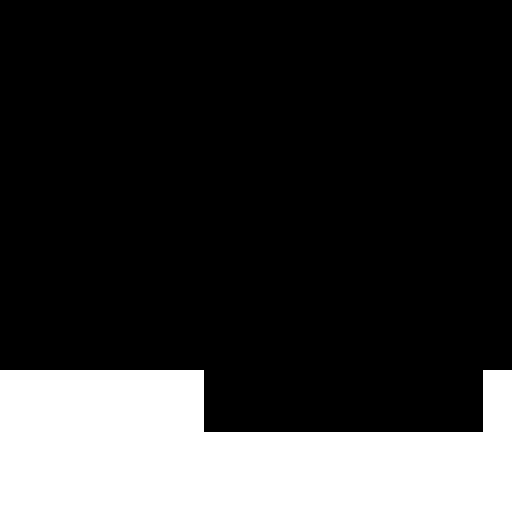

a photo of <OBJ_B>
(512, 512, 3) 255


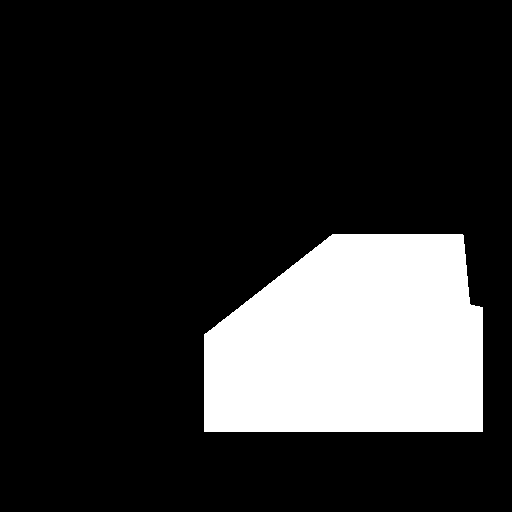

a photo of <OBJ_C>
(512, 512, 3) 255


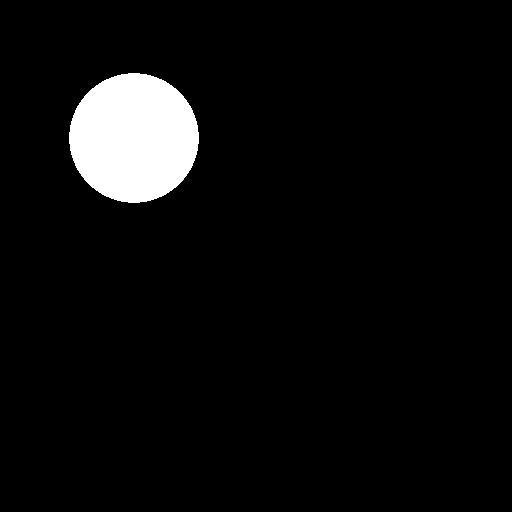

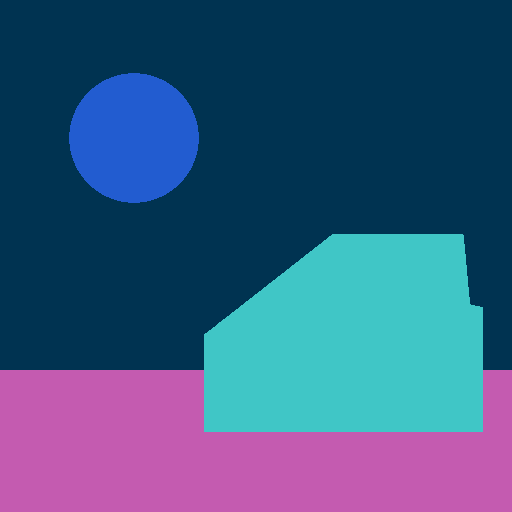

['a photo of {<OBJ_B>:13026880} {<OBJ_A>:11557828} Background is {<OBJ_D>:5321472} with {<OBJ_C>:13655074}.']
{5321472: {'caption': 'a photo of <OBJ_D>'}, 11557828: {'caption': 'a photo of <OBJ_A>'}, 13026880: {'caption': 'a photo of <OBJ_B>'}, 13655074: {'caption': 'a photo of <OBJ_C>'}}


In [47]:
fp = 'evaldata/openair.psd'

torch.manual_seed(48)
prototype = psd_to_cocopanoptic(fp)
display_example(prototype)

In [72]:
possibilities = {
    "<OBJ_A>": ["in the {desert}", "floating in the {sea}", "standing on the {ground}", "standing on {grass}"],
    "<OBJ_B>": ["a doll house", "a container ship", "an old shack", "a car"],
    ("<OBJ_D>", "<OBJ_C>"): [(["a dark starry night sky"], ["the moon", "a blood red moon", "a hot air balloon"]), (["a blue sky"], ["the sun", "the moon", "a hot air balloon", "the death star"]), (["a lush green forest"], ["a magical fire orb", "a red balloon"])]
}

def get_possibilities2(ps):
    ret = []
    if len(ps) == 0:
        return [{}]
    for k in ps.keys():
        vs = ps[k]
        del ps[k]
        downposs = get_possibilities(ps)
        for e in downposs:
            if isinstance(k, tuple):
                pass
            else:
                for ve in vs:
                    e_copy = deepcopy(e)
                    e_copy[k] = ve
                    ret.append(e_copy)
        break
    return ret

def get_possibilities(ps):
    ret = [{}]
    for k, vs in ps.items():
        newret = []
        for e in ret:
            for ve in vs:
                if isinstance(k, tuple):
                    assert isinstance(ve, tuple)
                    ves = itertools.product(*ve)
                    for vee in ves:
                        e_copy = deepcopy(e)
                        for ke, veee in zip(k, vee):
                            e_copy[ke] = veee
                        newret.append(e_copy)
                else:
                    e_copy = deepcopy(e)
                    e_copy[k] = ve
                    newret.append(e_copy)
        ret = newret
    return ret
    
pss = get_possibilities(possibilities)
print(len(pss))
    
specs = pss
random.shuffle(specs)
specs = specs[:20]
for psse in specs:
    print(psse)
    
    

144
{'<OBJ_A>': 'in the {desert}', '<OBJ_B>': 'a doll house', '<OBJ_D>': 'a blue sky', '<OBJ_C>': 'a hot air balloon'}
{'<OBJ_A>': 'standing on {grass}', '<OBJ_B>': 'a container ship', '<OBJ_D>': 'a blue sky', '<OBJ_C>': 'the death star'}
{'<OBJ_A>': 'in the {desert}', '<OBJ_B>': 'an old shack', '<OBJ_D>': 'a lush green forest', '<OBJ_C>': 'a magical fire orb'}
{'<OBJ_A>': 'standing on the {ground}', '<OBJ_B>': 'an old shack', '<OBJ_D>': 'a dark starry night sky', '<OBJ_C>': 'the moon'}
{'<OBJ_A>': 'floating in the {sea}', '<OBJ_B>': 'a container ship', '<OBJ_D>': 'a dark starry night sky', '<OBJ_C>': 'the moon'}
{'<OBJ_A>': 'standing on {grass}', '<OBJ_B>': 'a car', '<OBJ_D>': 'a dark starry night sky', '<OBJ_C>': 'the moon'}
{'<OBJ_A>': 'floating in the {sea}', '<OBJ_B>': 'a container ship', '<OBJ_D>': 'a blue sky', '<OBJ_C>': 'the death star'}
{'<OBJ_A>': 'in the {desert}', '<OBJ_B>': 'a container ship', '<OBJ_D>': 'a dark starry night sky', '<OBJ_C>': 'a hot air balloon'}
{'<OBJ_A>

In [74]:
examples = []
for spec in specs:
    x = replace_in_captions(prototype, spec)
    # display_example(x)
    examples.append(x)
    
Path("evaldata").mkdir(exist_ok=True)
with open("evaldata/openair1.pkl", "wb") as f:
    pkl.dump(examples, f)